# Final Main Implementation v.5

> This is a the main CNN implementation to recognize images of sign language digits.

In [29]:
# libraries:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

### Loading and preprocessing the data

In [30]:
# Defining a CNN model
def build_cnn(input_shape=(64, 64, 1), num_classes=10):
    model = models.Sequential([
        # Convolutional Layers
        # Stem
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        #layers.Dropout(0.1),
        
        # Core
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        #layers.Dropout(0.1),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        #layers.Dropout(0.1),

        # Head
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer='l2'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [31]:
# Load images and labels
X = np.load('data/X.npy').astype('float32')
y = np.load('data/Y.npy')

In [32]:
# Add channel dimension (grayscale)
X = X.reshape(-1, 64, 64, 1)  # New shape: (2062, 64, 64, 1)

In [33]:
k = 10  # Typical value, but you can experiment
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [34]:
# Data Augmentation: helps increase the diversity of training data
# by applying random transformations like rotation and zoom
train_datagen = ImageDataGenerator(
    rotation_range=15,           # Randomly rotate images in the range (degrees)
    zoom_range=0.1,              # Randomly zoom images
    width_shift_range=0.1,       # Randomly shift images horizontally
    height_shift_range=0.1,       # Randomly shift images vertically
    cval=0                       # Fill value for empty areas
)

val_datagen = ImageDataGenerator()

### Main CNN Implementation with k-fold CV

In [35]:
# Lists to store history from each fold
accuracies = []
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []

In [36]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [37]:
for train_index, val_index in kf.split(X):
    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Convert one-hot labels to integers 
    y_train = np.argmax(y_train, axis=1)
    y_val = np.argmax(y_val, axis=1)

    # Create generators
    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
    
    # Create and train model (you'll need to reinitialize your model each time)
    model = build_cnn()  # Your model creation function
    history = model.fit(train_generator, 
                       validation_data=val_generator,
                       epochs=30,
                       callbacks=callbacks)
    
    # Evaluate and store accuracy
    val_acc = model.evaluate(X_val, y_val)[1]
    accuracies.append(val_acc)

    # Store metrics
    all_train_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])


Epoch 1/30


/Users/anthamorious/Library/Mobile Documents/com~apple~CloudDocs/University/University of Houston/Semesters/🎓 Spring 2025/🌹 COSC 4337 - Data Science II/Project/Final report/COSC4337-project-main/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/anthamorious/Library/Mobile Documents/com~apple~CloudDocs/University/University of Houston/Semesters/🎓 Spring 2025/🌹 COSC 4337 - Data Science II/Project/Final report/COSC4337-project-main/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do 

58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.3244 - loss: 3.6981 - val_accuracy: 0.1932 - val_loss: 6.6266 - learning_rate: 0.0010
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.6231 - loss: 2.2871 - val_accuracy: 0.1063 - val_loss: 8.2825 - learning_rate: 0.0010
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.7099 - loss: 1.8203 - val_accuracy: 0.1063 - val_loss: 5.3879 - learning_rate: 0.0010
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8024 - loss: 1.4872 - val_accuracy: 0.2415 - val_loss: 4.1897 - learning_rate: 0.0010
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8589 - loss: 1.2164 - val_accuracy: 0.1836 - val_loss: 4.5221 - learning_rate: 0.0010
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8811 - loss: 1.0022 - val_accuracy: 0.1063 - val_loss: 5.5345 - learning_rate: 0.0010
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.8816 - loss: 0.9189 - val_accuracy: 0.20

In [38]:
model.save('sign_language_digits.h5')  # Save the trained model

### Viewing CNN Statistics Accuracy & Loss

In [39]:
def plot_avg_accuracy(train_acc, val_acc):
    avg_train_acc = np.mean(train_acc, axis=0)
    avg_val_acc = np.mean(val_acc, axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(avg_train_acc, label='Training Accuracy')
    plt.plot(avg_val_acc, label='Validation Accuracy')
    plt.title('Average Training & Validation Accuracy Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [40]:
def plot_avg_loss(train_loss, val_loss):
    avg_train_loss = np.mean(train_loss, axis=0)
    avg_val_loss = np.mean(val_loss, axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(avg_train_loss, label='Training Loss')
    plt.plot(avg_val_loss, label='Validation Loss')
    plt.title('Average Training & Validation Loss Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [41]:
def plot_individual_folds(metric, title, ylabel):
    plt.figure(figsize=(10, 5))
    for i, fold_metric in enumerate(metric):
        plt.plot(fold_metric, label=f'Fold {i+1}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [42]:
def plot_overlaid_folds(train_metric, val_metric, metric_name):
    plt.figure(figsize=(12, 6))
    
    # Plot all training metrics
    for i, fold_metric in enumerate(train_metric):
        plt.plot(fold_metric, color='blue', alpha=0.2, linestyle='-')
    
    # Plot all validation metrics
    for i, fold_metric in enumerate(val_metric):
        plt.plot(fold_metric, color='orange', alpha=0.2, linestyle='-')
    
    # Plot averages
    plt.plot(np.mean(train_metric, axis=0), color='blue', 
             linewidth=2, label='Avg Training')
    plt.plot(np.mean(val_metric, axis=0), color='orange', 
             linewidth=2, label='Avg Validation')
    
    plt.title(f'Training & Validation {metric_name} Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

In [43]:
print(f"Average validation accuracy: {np.mean(accuracies):.2%}")

Average validation accuracy: 99.42%


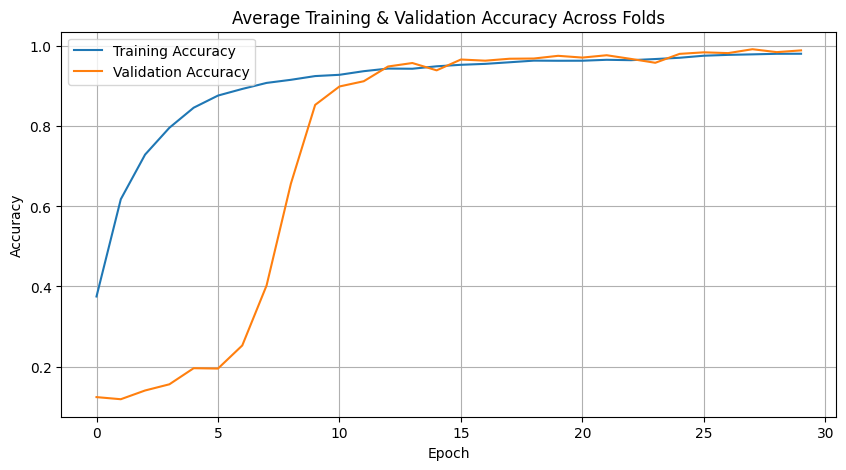

In [44]:
# Plotting average accuracy
plot_avg_accuracy(all_train_acc, all_val_acc)

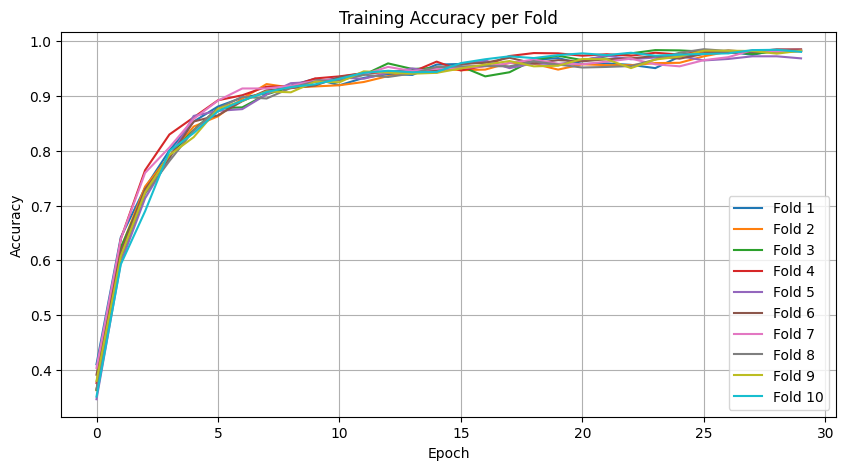

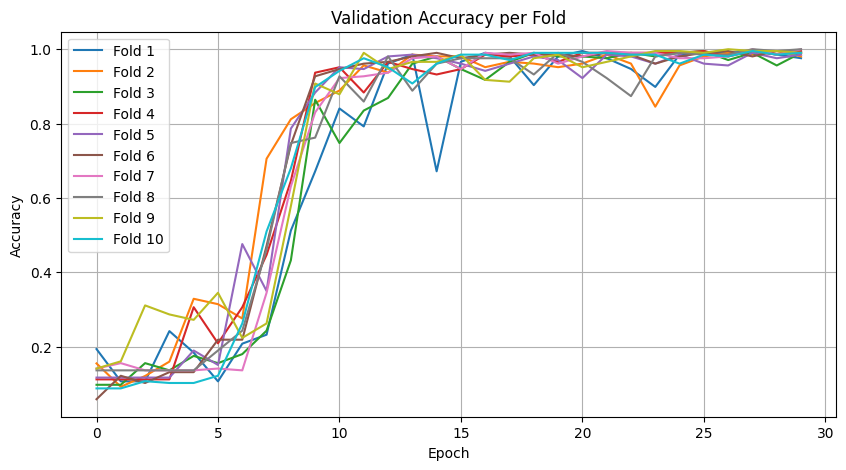

In [45]:
# Plot individual folds accuracy
plot_individual_folds(all_train_acc, 'Training Accuracy per Fold', 'Accuracy')
plot_individual_folds(all_val_acc, 'Validation Accuracy per Fold', 'Accuracy')

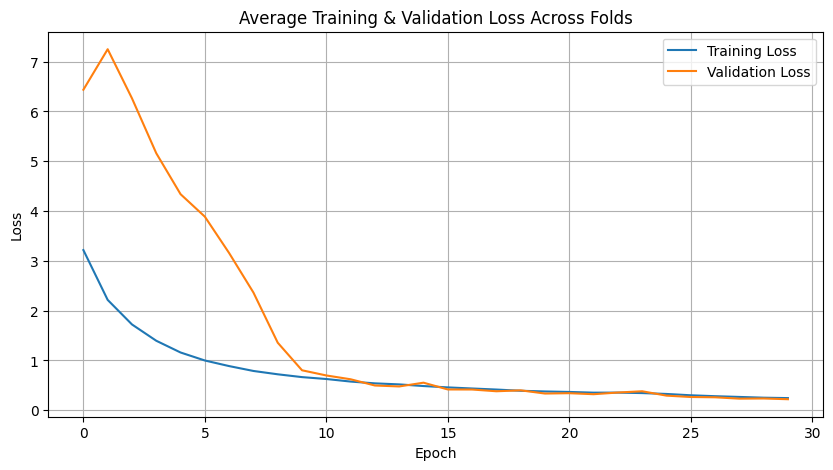

In [46]:
# Plotting average loss
plot_avg_loss(all_train_loss, all_val_loss)

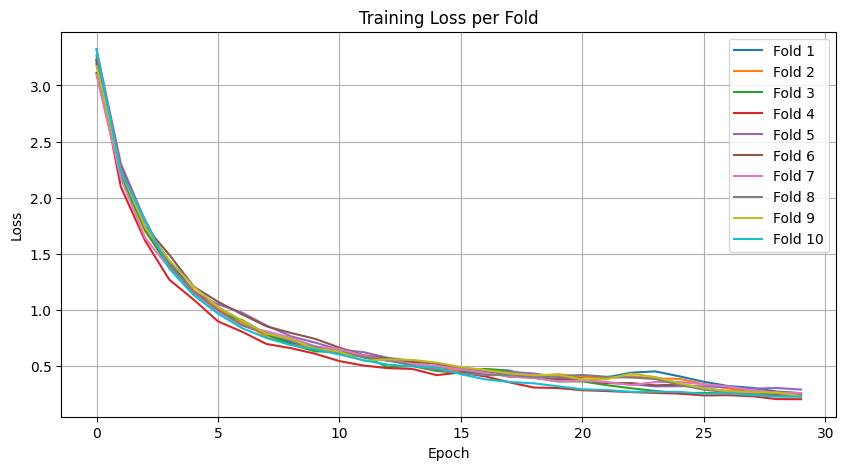

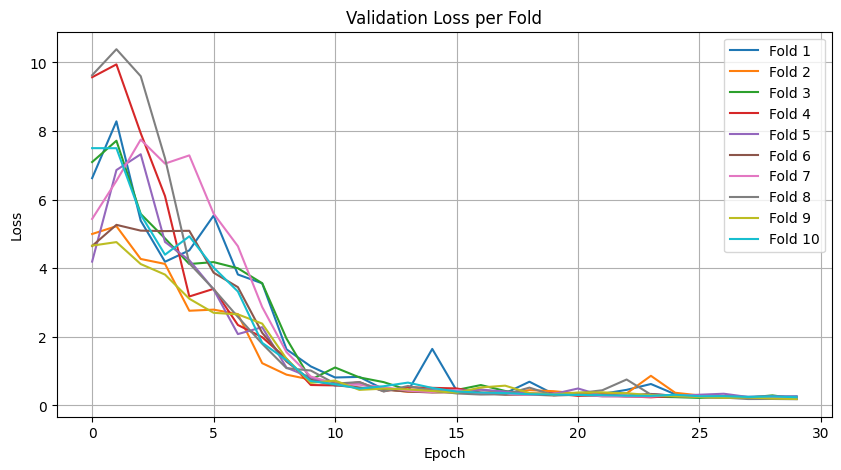

In [47]:
# Plot individual folds loss
plot_individual_folds(all_train_loss, 'Training Loss per Fold', 'Loss')
plot_individual_folds(all_val_loss, 'Validation Loss per Fold', 'Loss')

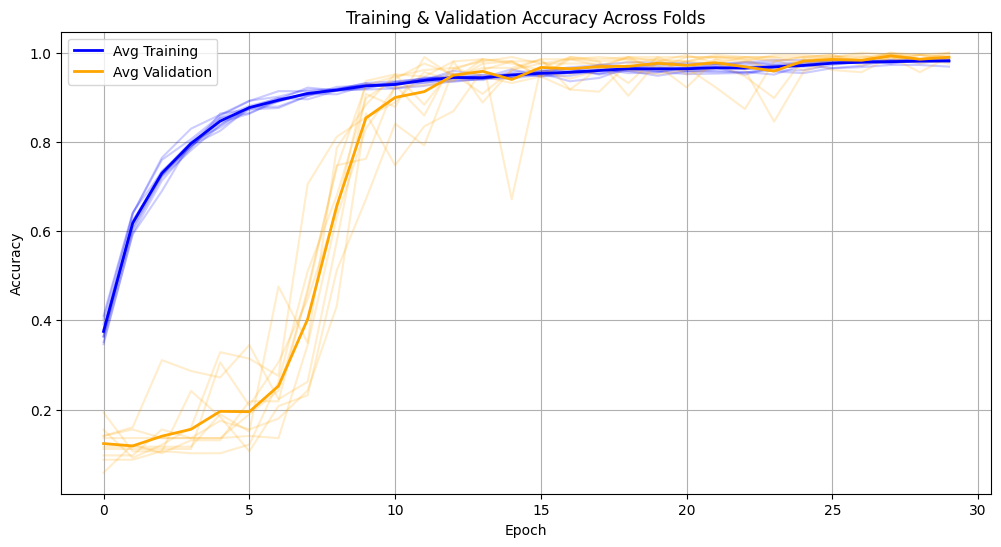

In [48]:
plot_overlaid_folds(all_train_acc, all_val_acc, 'Accuracy')

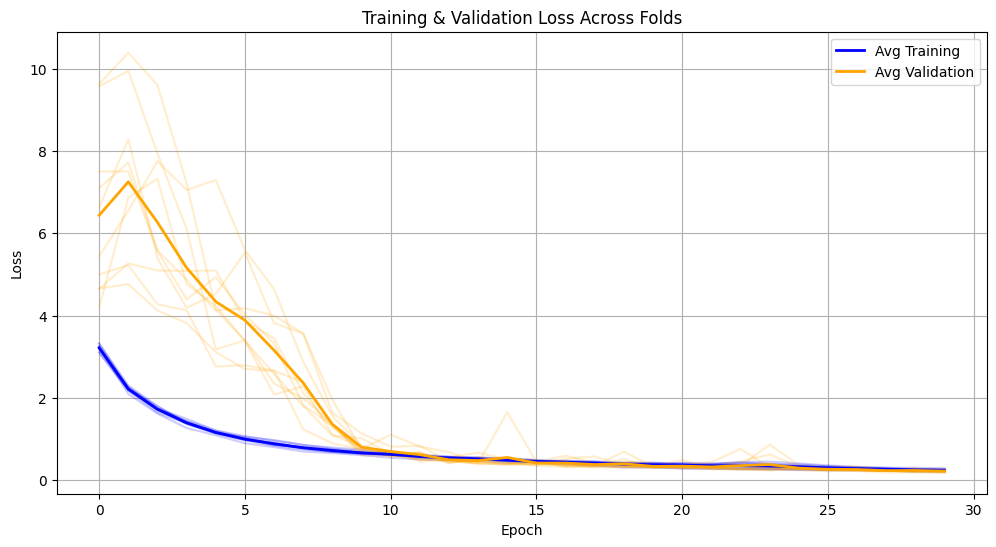

In [49]:
plot_overlaid_folds(all_train_loss, all_val_loss, 'Loss')

### Evaluating Model Predictions

In [50]:
# Initialize lists to store all predictions and true labels
all_y_true = []
all_y_pred = []

In [51]:
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"\nEvaluating Fold {fold + 1}/{k}")
    
    # Get validation data
    X_val = X[val_index]
    y_val = y[val_index]
    
    # Convert one-hot if needed
    if y_val.ndim > 1:
        y_val = np.argmax(y_val, axis=1)
    
    # Create generator with same preprocessing as validation
    val_generator = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)
    
    # Predict
    y_pred = model.predict(val_generator, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    
    # Store results
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)


Evaluating Fold 1/10

Evaluating Fold 2/10

Evaluating Fold 3/10

Evaluating Fold 4/10

Evaluating Fold 5/10

Evaluating Fold 6/10

Evaluating Fold 7/10

Evaluating Fold 8/10

Evaluating Fold 9/10

Evaluating Fold 10/10


In [52]:
# Convert nested arrays to 1D
all_y_true = np.array([x[0] if isinstance(x, (list, np.ndarray)) else x for x in all_y_true])
all_y_pred = np.array([x[0] if isinstance(x, (list, np.ndarray)) else x for x in all_y_pred])


In [53]:
print("Flattened shapes:")
print("y_true:", all_y_true.shape, "| Sample:", all_y_true[:5])
print("y_pred:", all_y_pred.shape, "| Sample:", all_y_pred[:5])


Flattened shapes:
y_true: (2062,) | Sample: [0 0 0 0 0]
y_pred: (2062,) | Sample: [0 0 0 0 0]


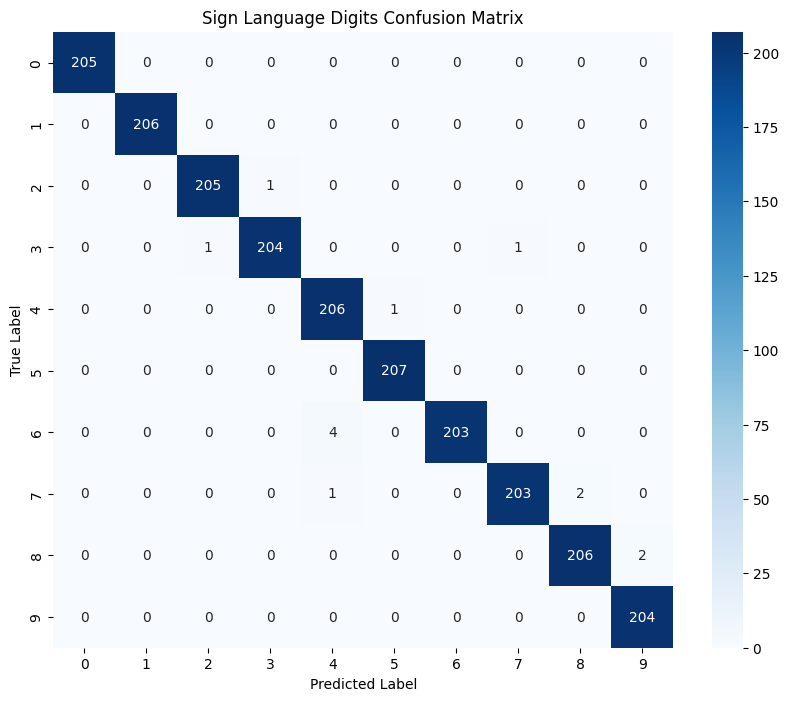

In [54]:
# Calculate confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot with Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), 
            yticklabels=range(10))
plt.title('Sign Language Digits Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [55]:
# Get precision, recall, f1-score (Classification report)
report = classification_report(all_y_true, all_y_pred, 
                               target_names=[str(i) for i in range(10)])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       205
           1       1.00      1.00      1.00       206
           2       1.00      1.00      1.00       206
           3       1.00      0.99      0.99       206
           4       0.98      1.00      0.99       207
           5       1.00      1.00      1.00       207
           6       1.00      0.98      0.99       207
           7       1.00      0.99      0.99       206
           8       0.99      0.99      0.99       208
           9       0.99      1.00      1.00       204

    accuracy                           0.99      2062
   macro avg       0.99      0.99      0.99      2062
weighted avg       0.99      0.99      0.99      2062

